# Diamond Princess Cruise Ship 

> H. C. R. Oliveira, V. Shmerko and S. N. Yanushkevich, "Decision Support for Infection Outbreak Analysis: the case of the Diamond Princess cruise ship," 2021 IEEE Symposium Series on Computational Intelligence (SSCI), 2021, pp. 1-8, doi: [10.1109/SSCI50451.2021.9660140](https://ieeexplore.ieee.org/document/9660140).

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# for reproducibility
# must to run this before create the BN! 
# Even in the cases where the states names were changed 
r_seed = 101
gum.initRandom(r_seed) 
random.seed(r_seed)

%matplotlib inline

#### Auxiliar functions

In [2]:
def norm_dist(x, mean, std_dev):
    dist = norm.pdf(x, loc=mean, scale=std_dev, random_state=r_seed)
    dist = dist / np.sum(dist)
    return dist

def tnorm_dist(mean, std_dev, bins=None, size=100000):
    '''TNormal as Fenton's book p.279'''
    d = norm.rvs(size=size, loc=mean, scale=std_dev, random_state=r_seed)
    hist,bins = np.histogram(d, bins=bins, density=True, range=(0,1))
    return (hist,bins)

## Data Analysis

#### Test Accuracy

In [3]:
# from Neils paper Table 1
df_tests = pd.DataFrame({'Company':['Roche', 'Kurabo', 'Biotech', 
                                    'EuroImmun', 'BioMedomics', 
                                    'OrientBiotech'],
                         'nFP': [5272, 521, 371, 80, 128, 500],
                         'FP': [10, 0, 2, 0, 12, 0],
                         'nFN': [29, 500, 160, 30, 397, 500],
                         'FN':[0, 100, 7, 3, 45, 75]
                        })

# Neil's paper has wrong names
df_tests.rename(columns={"nFP": "nP", "nFN": "nN"}, inplace=True)

# wikipedia is wrong on FPR and FNR
df_tests['FPR'] = df_tests['FP'] / df_tests['nP']
df_tests['FNR'] = df_tests['FN'] / df_tests['nN']

# Specificity: 1 - FPR 
df_tests['Specificity'] = (1 - df_tests['FPR']) * 100
# Sensitivity: 1 - FNR
df_tests['Sensitivity'] = (1 - df_tests['FNR']) * 100
df_tests

,Company,nP,FP,nN,FN,FPR,FNR,Specificity,Sensitivity
0,Roche,5272,10,29,0,0.001897,0.00000,99.810319,100.000000
1,Kurabo,521,0,500,100,0.000000,0.20000,100.000000,80.000000
2,Biotech,371,2,160,7,0.005391,0.04375,99.460916,95.625000
3,EuroImmun,80,0,30,3,0.000000,0.10000,100.000000,90.000000
4,BioMedomics,128,12,397,45,0.093750,0.11335,90.625000,88.664987
5,OrientBiotech,500,0,500,75,0.000000,0.15000,100.000000,85.000000


In [4]:
df_tests2 = df_tests.drop('Company', axis=1)
df_stats = pd.DataFrame({'Mean':df_tests2.mean(), 
                         'Std':df_tests2.std()})
df_stats = df_stats.T
df_stats

,nP,FP,nN,FN,FPR,FNR,Specificity,Sensitivity
Mean,1145.333333,4.00000,269.333333,38.333333,0.016840,0.101183,98.316039,89.881665
Std,2030.030509,5.51362,223.475875,42.169499,0.037737,0.071880,3.773669,7.188030


#### Other data

In [5]:
# Diamond Princess: 712 infected out of 3711 (passengers + crew)
NI = 712
NP = 3711
IPR = NI/NP
print('IPR: %.4f' % (IPR))
print('IPR considered as 0.2 (20%) for calculations in the paper')
IPR = 0.2

# PTR (based on Neil's paper)
# P = IPR x (1-FNR) + (1-IPR) x FPR.
print('P = IPR x (1-FNR) + (1-IPR) x FPR = %.4f' % (IPR * (1-df_stats['FNR']['Mean']) + (1-IPR) * df_stats['FPR']['Mean']))

# JIID's report, 2020
n_symp = [0, 2, 25, 27, 19, 28, 76, 95, 27, 2]
n_asymp = [1, 3, 3, 7, 8, 31, 101, 139, 25, 0]
print('Infected w/ symptoms: %.4f' % (np.sum(n_symp)/3711))
print('Infected w/o symptoms: %.4f' % (np.sum(n_asymp)/3711))

# Diamond Princess: 14 deaths (0.3776%) (JIID)
print('Deaths: 14 (JIID), %.4f%%' % (14/NP*100))

IPR: 0.1919
IPR considered as 0.2 (20%) for calculations in the paper
P = IPR x (1-FNR) + (1-IPR) x FPR = 0.1932
Infected w/ symptoms: 0.0811
Infected w/o symptoms: 0.0857
Deaths: 14 (JIID), 0.3773%


# Original BN

In [6]:
bn = gum.fastBN('Age{0-9|10-19|20-29|30-39|40-49|50-59|60-69|70-79|80-89|90-99}->PofS{not susceptible|susceptible};' +
                'Gender{male|female}->PofS;' +
                'PofS->COVID-19 Status{Infected, w/ Symptoms|Infected, w/o Symptoms|Not Infected};' +
                'COVID-19 Status->Tested Positive{no|yes};' +
                'FNR{1%|2%|3%|4%|5%|6%|7%|8%|9%|10%|11%|12%|13%|14%|15%}->Tested Positive;' +
                'FPR{0.25%|0.50%|0.75%|1.00%|1.25%|1.50%|1.75%|2.00%|2.25%|2.50%|2.75%|3.00%}->Tested Positive;' +
                'IPR{<=13%|14%|15%|16%|17%|18%|19%|20%|21%|22%|23%|24%|>=25%}->Tested Positive;' +
                'IPR->COVID-19 Status;' +
                'COVID-19 Status->IFR{0.0%|0.1%|0.2%|0.3%|0.4%|0.5%|0.6%|0.7%|0.8%|0.9%|1.0%}')

#gnb.showBN(bn, size='9')
bn.cpt('Age').fillWith(1).normalize()
bn.cpt('Gender').fillWith(1).normalize()
bn.cpt('PofS').fillWith(1).normalize()
bn.cpt('FNR').fillWith(1).normalize()
bn.cpt('FPR').fillWith(1).normalize()
bn.cpt('IPR').fillWith(1).normalize()
bn.cpt('COVID-19 Status').fillWith(1).normalize()
bn.cpt('IFR').fillWith(1).normalize()

bn

(pyAgrum.BayesNet<double>@0x24458b31c80) BN{nodes: 9, arcs: 9, domainSize: 10^6.79082, dim: 14243}

# Populating the CPTs

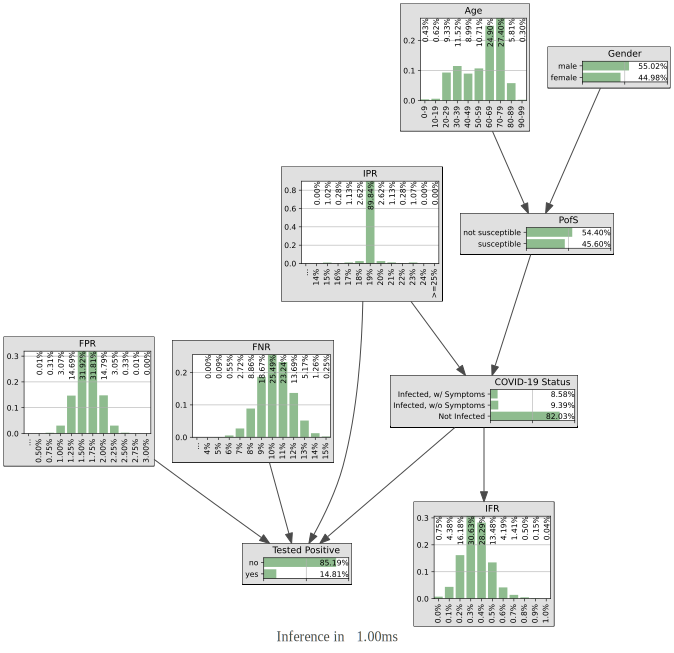

In [7]:
## male, female
bn.cpt('Gender')[:] = [0.55, 0.45]

# median age (Moryarti, 2020): 
#    crew: 36yo (IQR 29-43) 
#    passenger: 69yo (IQR 62-73)
# considering age [0-50 51-100]
# stratified data from JIID's report, 2020
total_age = [16, 23, 347, 428, 334, 398, 923, 1015, 216, 11]
bn.cpt('Age')[:] = np.divide(total_age, NP)

# false negative rates of between 2% and 29% (equating to sensitivity of 71-98%)
# FPR: 0.25% interval, peak at 1.68%
# 12 states: 0.25%|0.50%|0.75%|1.00%|1.25%|1.50%|1.75%|2.00%|2.25%|2.50%|2.75%|3.00%
FPR_v,_ = tnorm_dist(mean=0.5, std_dev=np.sqrt(0.0168 / 2), bins=12)
bn.cpt('FPR')[:] = FPR_v / np.sum(FPR_v)

# FNR: 1% interval, peak at 10.12%
# 15 states: 1%|2%|3%|4%|5%|6%|7%|8%|9%|10%|11%|12%|13%|14%|15%
FNR_v,_ = tnorm_dist(mean=0.65, std_dev=np.sqrt(0.1012 / 10), bins=15)
bn.cpt('FNR')[:] = FNR_v / np.sum(FNR_v)

# How "susceptible" a person is based on "age":
# Age{0-9|10-19|20-29|30-39|40-49|50-59|60-69|70-79|80-89|90-99}
age_w = [(x+1.2) * 1 for x in range(1,11)]

# PofS
for gender in {0,1}:
    gender_w = 0.4 if gender == 0 else 0.2
    for i,age_prop in enumerate(bn.cpt('Age').tolist()):
        # weight for each age interval
        pofs_sus = age_w[i] * gender_w * age_prop
        # sometimes pofs_sus is higher than 1, so 1-pofs_sus will be negative
        pofs_sus = pofs_sus if pofs_sus <= 1 else 1
        # normalize to avoid get out of bounds
        pofs = [1-pofs_sus, pofs_sus]
        pofs = pofs / np.sum(pofs)
        bn.cpt('PofS')[{'Gender':gender, 'Age':i}] = pofs        

# IPR: for Diamond Princess is around 19.18%
# 13 states:  <=13%|14%|15%|16%|17%|18%|19%|20%|21%|22%|23%|24%|>=25%
IPR_v,_ = tnorm_dist(mean=0.5, std_dev=np.sqrt(0.1012 / 10), bins=13)
bn.cpt('IPR')[:] = IPR_v / np.sum(IPR_v)

# COVID-19 Status
# Inf. w/ Symp.: 0; Inf. w/o Symp.: 1; Not Inf.: 2
# parents: IPR, PofS
bn.cpt('COVID-19 Status')[{'IPR':2, 'PofS':0}] = [0.02, 0.02, 0.94]
bn.cpt('COVID-19 Status')[{'IPR':2, 'PofS':1}] = [0.04, 0.05, 0.91]
bn.cpt('COVID-19 Status')[{'IPR':6, 'PofS':0}] = [0.04, 0.05, 0.91]
bn.cpt('COVID-19 Status')[{'IPR':6, 'PofS':1}] = [0.09, 0.10, 0.81]
bn.cpt('COVID-19 Status')[{'IPR':10, 'PofS':0}] = [0.17, 0.12, 0.71]
bn.cpt('COVID-19 Status')[{'IPR':10, 'PofS':1}] = [0.27, 0.12, 0.61]


# 'Tested Positive' (2 states) depends on:
#    - COVID-19 Status: 3 states
#    - FNR: 15 states
#    - FPR: 12 states
#    - IPR: 13 states
# Fenton's paper: (IPR*(1-FNR)) + ((1-IPR)*FPR)
# Fenton's book "Boolean node" p. 253
for i in range(3): # COVID-19 Status
    for j in range(15): # FNR
        for k in range(12): # FPR
            for l in range(13): # IPR
                # Error Rates
                if (i == 0 or i == 1): # infected with and without symp.
                    er = bn.cpt('FNR')[j]
                else:
                    er = bn.cpt('FPR')[k]
                    
                # calculation based on COVID-19 status
                covs_w = 0.98 if (i == 0 or i == 1) else 0.02
                covs = covs_w * gum.getPosterior(bn, {}, 'COVID-19 Status')[i]

                # Infection Prevalence Rate
                ipr = bn.cpt('IPR')[l]

                # weighted average (Fenton p.)
                w = [1, 3, 2] # weights
                w = w / np.sum(w) # normalizing
                tpos_yes = (w[0]*er) + (w[1]*covs) + (w[2]*ipr)

                bn.cpt('Tested Positive')[{'COVID-19 Status':i,
                                           'FNR':j,
                                           'FPR':k,
                                           'IPR':l}] = [1-tpos_yes, tpos_yes]
bn.cpt('Tested Positive').normalizeAsCPT()

# Diamond Princess: 14 deaths (0.3776%) (JIID)
# IFR: 0.1% | 0.2% | 0.3% | 0.4% | 0.5% | 0.6% | 0.7%

# Infected w/ Symp
ifr_tmp,_ = tnorm_dist(mean=0.43, std_dev=np.sqrt(0.03), bins=11)
ifr = ifr_tmp / np.sum(ifr_tmp)
bn.cpt('IFR')[{'COVID-19 Status': 0}] = ifr

# Infected w/o Symp.
ifr_tmp,_ = tnorm_dist(mean=0.41, std_dev=np.sqrt(0.03), bins=11)
ifr = ifr_tmp / np.sum(ifr_tmp)
bn.cpt('IFR')[{'COVID-19 Status': 1}] = ifr

# Not Infected
ifr_tmp,_ = tnorm_dist(mean=0.35, std_dev=np.sqrt(0.01), bins=11)
ifr = ifr_tmp / np.sum(ifr_tmp)
bn.cpt('IFR')[{'COVID-19 Status': 2}] = ifr

gnb.showInference(bn, evs={}, size='45')

# Scenarios

### Protocol #01

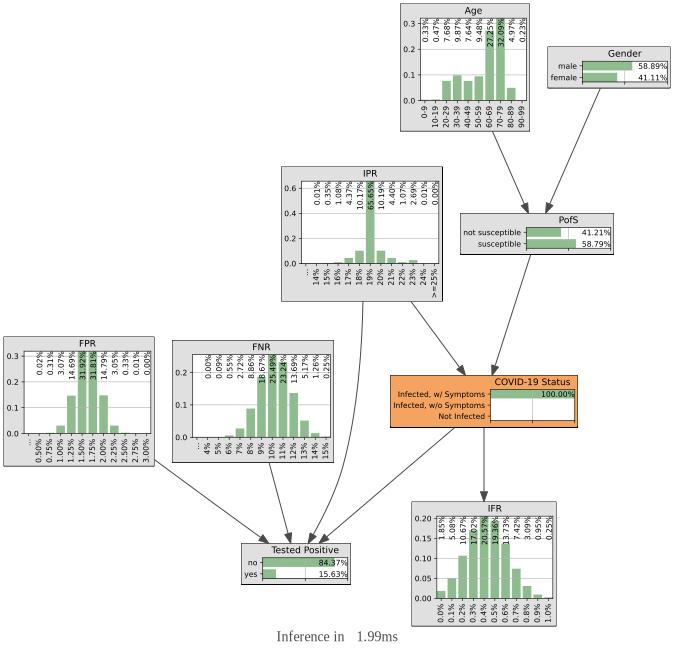

In [8]:
evs = {'COVID-19 Status':0}
gnb.showInference(bn, size='10', evs=evs)

### Protocol #02: TPos, IFR vs. CovS

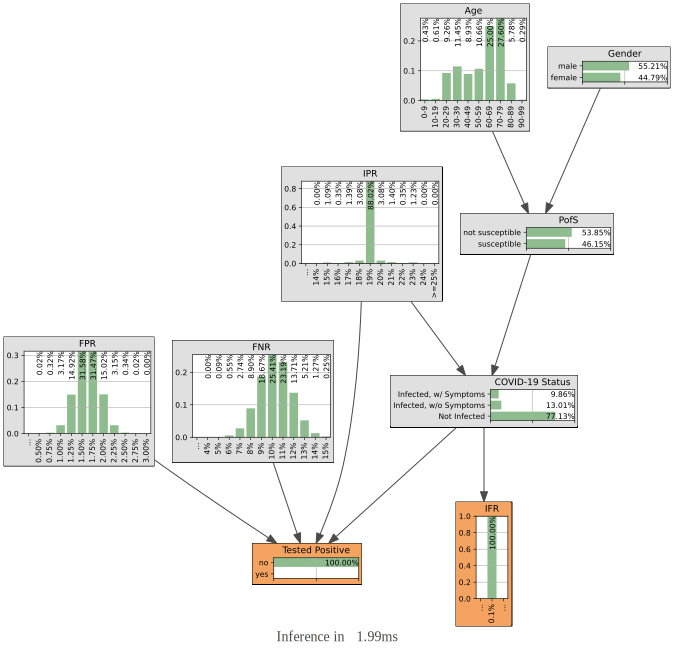

In [9]:
evs= {'Tested Positive':0, 'IFR':1}
gnb.showInference(bn, size='10', evs=evs)

### Protocol #03: IPR vs. CovS, IFR

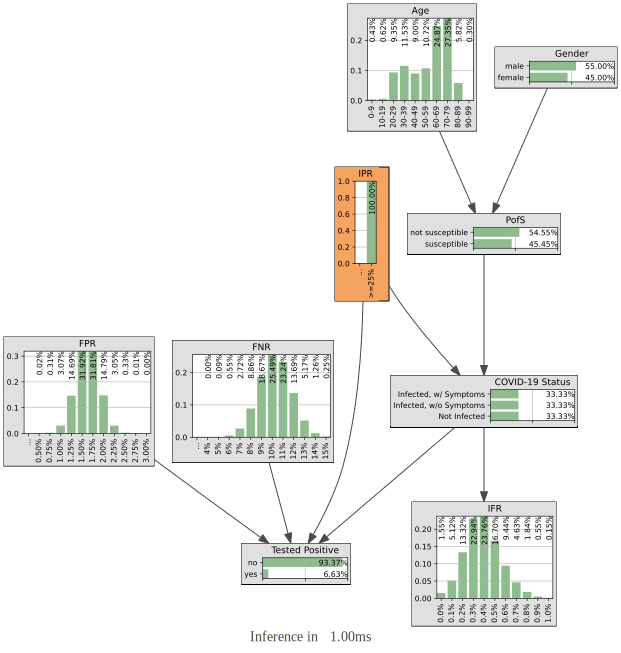

In [10]:
evs = {'IPR':12}
gnb.showInference(bn, size='10', evs=evs)